In [4]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [6]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [7]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [8]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [9]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]
adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_19414/3783398913.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 11.11659513590844
Number of clusters 1398
Metrics based on additionally filtering by 25 cells per cluster
Average cells per cluster 133.89285714285714
Number of clusters 84


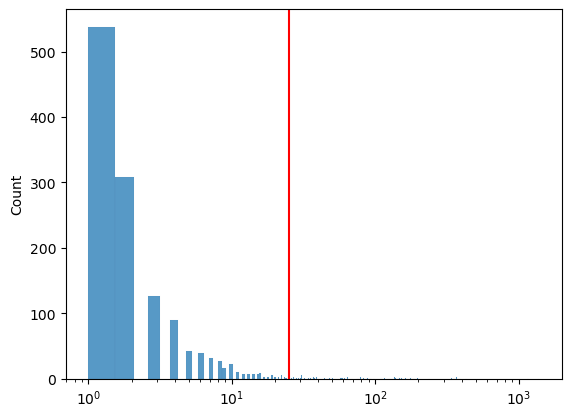

In [10]:
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
# n_cells_per_cluster_cutoff = 10
n_cells_per_cluster_cutoff = 25

# using the clustering to call clones
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))


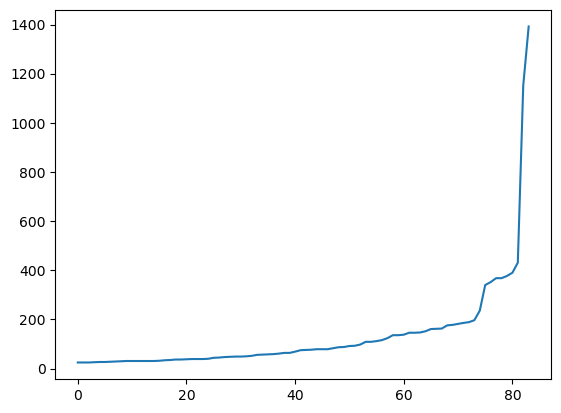

In [11]:
plt.plot(sorted(cluster_sizes))

In [12]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [13]:
# calculate the statistics for clones
real_delta  = group_delta_mean(confident_clusters,'bc_cluster')
# perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=1000)
perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=119*100)
perm_deltas = permuted_group_delta_means(confident_clusters,'bc_cluster',n_perms=12000)

# calculate the scores and p-values for the clones
scores = calculate_group_scores(real_delta,pd.DataFrame(perm_deltas))
p_vals = calculate_empirical_p_values(real_delta,pd.DataFrame(perm_deltas))

In [14]:
### SAVE CLONE score output

clone_score_df = pd.DataFrame({'gene':scores.index,'score':scores,'p_val':p_vals})

clone_score_df.to_csv(f'../extractedData/clone_scores_{n_cells_per_cluster_cutoff}cellspercluster.csv',index=False)

In [17]:
def calculate_empirical_p_values_lower(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] <= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

In [19]:
p_low = calculate_empirical_p_values_lower(real_delta,pd.DataFrame(perm_deltas))


In [25]:
pd.DataFrame(perm_deltas)

,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,CCNA2,...,TRPM1,TYR,VCAM1,VEGFA,VEGFC,VGF,WNT5A,YAP1,ZEB1,ZEB2
0,1.844729,0.285714,3.530811,0.135593,1.738487,0.050000,0.140000,2.650371,8.205390,0.986352,...,0.483021,3.474286,0.078947,2.537419,0.194940,2.127321,0.129032,0.838235,0.320000,1.010585
1,1.351763,0.175000,3.133117,0.189189,1.742564,0.074074,0.200000,2.767857,8.774436,0.821909,...,0.510000,2.957370,0.080645,2.262632,0.243243,1.286022,0.153846,0.743048,0.245390,1.009456
2,2.157509,0.230769,4.272014,0.142857,1.681429,0.103448,0.159420,2.214854,8.603846,0.792614,...,0.718750,2.883375,0.102564,2.321429,0.228070,2.332712,0.225806,0.745185,0.178571,1.021739
3,2.011785,0.200000,4.084103,0.086957,2.124288,0.093750,0.193548,3.051282,10.241087,0.828341,...,0.518919,3.491898,0.163265,2.513553,0.243243,1.166667,0.153846,0.817391,0.222222,1.384419
4,1.458120,0.256410,3.816729,0.120000,1.475556,0.085714,0.142857,2.606838,8.575000,0.720965,...,0.502041,2.652136,0.135135,2.231128,0.249793,2.420000,0.193548,0.726815,0.257143,1.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11895,1.828125,0.270833,3.801411,0.225000,1.792821,0.129032,0.136364,2.986667,8.904615,0.996923,...,0.449445,3.234074,0.079545,1.969032,0.354839,1.718421,0.148936,0.892780,0.290323,1.275000
11896,1.357419,0.210526,2.797758,0.204082,1.911012,0.081967,0.178571,2.663265,8.128205,0.629870,...,0.491892,4.202112,0.101695,1.954023,0.229508,1.602564,0.176471,0.619355,0.197235,0.794872
11897,1.697778,0.250000,4.657109,0.129032,1.589744,0.085714,0.147059,4.610582,7.087216,0.658120,...,0.498462,3.148124,0.120000,1.910968,0.280000,1.319093,0.144737,0.682057,0.244444,0.960298
11898,1.527751,0.176471,2.968459,0.200000,1.845405,0.054054,0.139241,2.573574,7.075269,0.560713,...,0.633333,3.674839,0.111111,2.290323,0.216216,1.279101,0.132653,0.936596,0.225806,1.242294


In [24]:
p_low[p_low < 0.5]

BIRC3     0.305184
BMP4      0.357953
IFIT2     0.430552
KIT       0.301823
MERTK     0.457693
MMP11     0.427275
NOTCH3    0.483909
OASL      0.387026
PRKCA     0.282329
RIGI      0.274431
SOX2      0.084279
dtype: float64

Text(0.5, 0, 'Delta (IFIT2)')

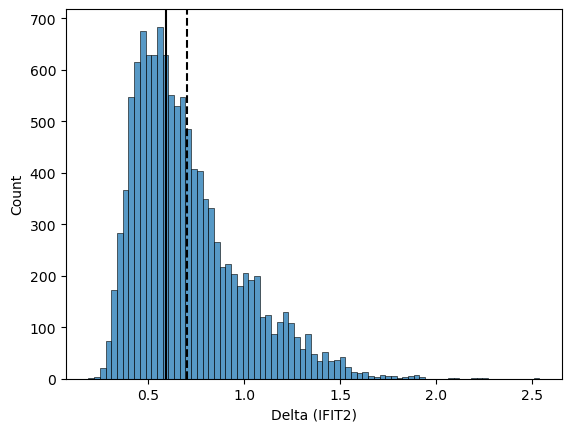

In [34]:
sns.histplot(pd.DataFrame(perm_deltas)['IFIT2'])
plt.axvline(real_delta['IFIT2'],color='k')

plt.axvline(np.mean(pd.DataFrame(perm_deltas)['IFIT2']),color='k',linestyle='--')

plt.xlabel('Delta (IFIT2)')


In [27]:
scores

AKT1     2.277399
AXL      1.017714
BGN      2.397452
BIRC3    0.782311
BIRC5    1.627229
           ...   
VGF      2.693612
WNT5A    1.515835
YAP1     2.042862
ZEB1     1.611402
ZEB2     1.883672
Length: 119, dtype: float64